# Box-Cox Transformation Experiment Notebook

This is the experiment using **Box-Cox Transformation** with 4 Digit MWC 4 Dataset. We have already experimented the transform using **logit function** `ln(x/(1-x))` but there are some beatmap that don't have the **Normally Distributed** score yet. So we try a (hopefully not too) complicated approach to make the data more Normally Distributed

---

## Procedure

In [ ]:
import os

os.chdir("..")

### Import Necessary Libraries

Here we are going to use `matplotlib.pyplot` to visualize the distribution of the data and `Dataset`class from [this repository](https://github.com/HowToProgramming/4dm4analysis) to deal with `sqlite` database

In [1]:
import matplotlib.pyplot as plt
from utils import Dataset

### Initialize the Dataset

In [2]:
_4dm4 = Dataset('datasets/4dm4.db')

### Define the Necessary functions to Query Data

- `query_by_round_type_tag` is used to query `player_name`, `score` and `score_logit` from the dataset where the maps are `round`, `type`, `tag` (for example `SF`, `HB`, `2`)
- `query_all_tags` is to query the map count of a `type` in a given `round`

In [3]:
def query_by_round_type_tag(round: str, type: str, tag: str):
    return _4dm4.select('scores', columns=['player_name', 'score', 'score_logit'], where={
        'round': f"\"{round}\"",
        'beatmap_type': f"\"{type}\"",
        'beatmap_tag': f"\"{tag}\""
    })

def query_all_tags(round: str, type: str):
    return _4dm4.query(f'SELECT DISTINCT beatmap_tag FROM scores WHERE round=\"{round}\" AND beatmap_type=\"{type}\"')

We test if the following functions work

In [4]:
query_by_round_type_tag("QF", "HB", "1").head()

,player_name,score,score_logit
0,HD_AdreNaline,983001,4.057456
1,Maid Bnot,973710,3.611925
2,FluffyGMD,960385,3.188126
3,Maykee kee,986240,4.272134
4,Zergh,970013,3.476546


In [5]:
query_all_tags("QF", "HB")

,beatmap_tag
0,1
1,2
2,3


### Defining Constants

We then define the `interested_rounds` we want to study (which is all rounds) and `interested_category` to be `RC`, `HB` and `LN`

In [6]:
interested_rounds = _4dm4.query("SELECT DISTINCT round FROM SCORES").values.flatten().tolist()
interested_category = ['RC', 'HB', 'LN']

interested_rounds

['Q', 'RO32', 'RO16', 'QF', 'SF', 'F', 'GF']

---

### Shapiro-Wilk test

We perform the **Shapiro-Wilk test** to check whether the data is **Normally Distributed** basically if the `scipy.stats.shapiro` yields the `p-value` **less than 0.05**, we can say that the data is not Normally Distributed. Otherwise...

*There is no turning back*

In [7]:
from scipy.stats import shapiro

We pull data (`score` and `score_logit`) from **QF RC 1** as a sample data

In [8]:
qf_rc_1 = query_by_round_type_tag('QF', 'RC', 1)

qf_rc_1_score = qf_rc_1['score'].values.flatten()
qf_rc_1_score_logit = qf_rc_1['score_logit'].values.flatten()

Then we perform the **Shapiro-Wilk test** on these data

In [9]:
shapiro(qf_rc_1_score)

ShapiroResult(statistic=0.8633033037185669, pvalue=0.0001148921437561512)

In [10]:
shapiro(qf_rc_1_score_logit)

ShapiroResult(statistic=0.9900920391082764, pvalue=0.9687826037406921)

As we seen from **QF RC 1**, the raw score is not **Normally Distributed** but the transformation using **logit function** did a really good job on normalizing the dataset. Let's see if it works for all beatmaps.

### Logit transformation always works ?

Here, we use **Shapiro-Wilk test** to verify that every beatmap has the Normally Distributed score (from logit transformation). We loop over all rounds, interested types and tags and print the beatmap that has the **p-value < 0.05** even with the **logit transformation**.

In [11]:
for rnd in interested_rounds:
    for cat in interested_category:
        tags = query_all_tags(rnd, cat).values.flatten()
        for t in tags:
            ds = query_by_round_type_tag(rnd, cat, t)
            stat, p = shapiro(ds['score_logit'].values.flatten())
            if p < 0.05:
                print(rnd, cat, t)
                print("Score", shapiro(ds['score'].values.flatten()))
                print("Logit Score", shapiro(ds['score_logit'].values.flatten()))

Q RC 1
Score ShapiroResult(statistic=0.5369417667388916, pvalue=3.89683049494445e-18)
Logit Score ShapiroResult(statistic=0.9424773454666138, pvalue=4.434710353962146e-05)
Q RC 2
Score ShapiroResult(statistic=0.4603457450866699, pvalue=2.184986731313283e-19)
Logit Score ShapiroResult(statistic=0.9615637063980103, pvalue=0.001359761692583561)
Q HB 1
Score ShapiroResult(statistic=0.7157858610153198, pvalue=3.034174677458111e-14)
Logit Score ShapiroResult(statistic=0.9766784906387329, pvalue=0.02920994907617569)
RO32 RC 1
Score ShapiroResult(statistic=0.6019769906997681, pvalue=1.1347306557926706e-12)
Logit Score ShapiroResult(statistic=0.9310038685798645, pvalue=0.0006876285187900066)
RO32 RC 3
Score ShapiroResult(statistic=0.5183445811271667, pvalue=1.3821357625835428e-14)
Logit Score ShapiroResult(statistic=0.956083357334137, pvalue=0.008922227658331394)
RO32 RC 4
Score ShapiroResult(statistic=0.7964321374893188, pvalue=0.0002577091217972338)
Logit Score ShapiroResult(statistic=0.91214

From this code, we can see that there are still many beatmaps which the scores are not **Normally Distributed** even with the **logit transformation**. We need another approach to make them more Normally Distributed.

---

### Box-Cox Transformation

#### What is Box-Cox Transformation ?

The **Box-Cox Transformation** aims to make the data as Normally Distributed as possible using the formula given below

```python
y = (x**lmbda - 1) / lmbda,  for lmbda != 0
    log(x),                  for lmbda = 0
```

The `scipy` python package provides the way to automatically find `lmbda` using **Maximum Likelihood** so we don't need to worry about finding `lmbda`.

For more information, you can read this [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) or [this Medium Article](https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203).

#### Performing Box-Cox Transformation

**Box-Cox Transformation** can be found in `scipy.stats` package

In [12]:
from scipy.stats import boxcox

We observe the **Q RC 1** score that has been transformed using logit function. This beatmap does not have a **Normally Distributed** score_logit.

In [13]:
# q rc1 is not normal

q_rc_1 = query_by_round_type_tag('Q', 'RC', 1)['score_logit']
q_rc_1

0      3.922366
1      4.792686
2      2.952871
3      5.119073
4      5.221730
         ...   
120    5.116538
121    5.196213
122    4.317018
123    2.180887
124    3.386818
Name: score_logit, Length: 125, dtype: float64

We perform the **Box-Cox Transformation**

In [14]:
bc, lmbda = boxcox(q_rc_1)

Then we observe the data using **Histogram**

(array([ 4.,  8., 16., 16., 34., 26., 16.,  2.,  1.,  2.]),
 array([ 2.58808424,  7.86531759, 13.14255094, 18.41978429, 23.69701764,
        28.97425099, 34.25148433, 39.52871768, 44.80595103, 50.08318438,
        55.36041773]),
 <BarContainer object of 10 artists>)

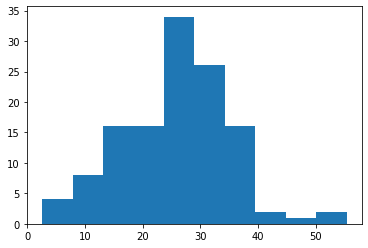

In [15]:
plt.hist(bc)

And do the **Shapiro-Wilk test** with transformed data again

In [16]:
shapiro(bc)

ShapiroResult(statistic=0.9832558035850525, pvalue=0.125358447432518)

The data looks **Normally Distributed** enough according to **p-value**

Then we observe the `lmbda` we get from **Box-Cox Transformation**

In [17]:
lmbda

2.639544280909197

#### Does it actually work ?

Here, we use **Shapiro-Wilk test** to verify that every beatmap has the Normally Distributed score (from logit transformation). We loop over all rounds, interested types and tags and print the beatmap that has the **p-value < 0.05** even after the **logit** and **Box-Cox Transformation**.

In [18]:
for rnd in interested_rounds:
    for cat in interested_category:
        tags = query_all_tags(rnd, cat).values.flatten()
        for t in tags:
            ds = query_by_round_type_tag(rnd, cat, t)['score_logit'].values.flatten()
            ds_boxcox, lmbda = boxcox(ds)
            stat, p = shapiro(ds)
            stat_bc, p_bc = shapiro(ds_boxcox)
            if p_bc < 0.05:
                print(rnd, cat, t)
                print("p shapiro Logit Score", p)
                print("p shapiro Logit Boxcox", p_bc)
                print("bc lambda", lmbda)

RO32 RC 3
p shapiro Logit Score 0.008922227658331394
p shapiro Logit Boxcox 0.011861970648169518
bc lambda 1.357919902536203
QF RC 2
p shapiro Logit Score 0.011168474331498146
p shapiro Logit Boxcox 0.015467197634279728
bc lambda 1.9400559184099562
QF RC 5
p shapiro Logit Score 0.014174080453813076
p shapiro Logit Boxcox 0.016421299427747726
bc lambda 0.6228948934925673


There are **RO32 RC 3**, **QF RC 2** and **QF RC 5** which are still not normally distributed.

We then observe these beatmaps using **Q-Q Plot** which is the plot to observe the residual from the given distributions (which is Normal Distribution in this case)

Here, we define the function to observe the **Q-Q Plot** of **Original Data** and **Box-Cox Transformed Data**

In [19]:
from scipy.stats import probplot, norm

def qqplotOriginalVSBoxCox(dataset):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    probplot(dataset, dist=norm, plot=ax)
    ax2 = fig.add_subplot(212)
    probplot(boxcox(dataset)[0], dist=norm, plot=ax2)

We then observe all beatmaps that are not **Normally Distributed** even with the **Box-Cox Transformation** and **Logit Transformation**

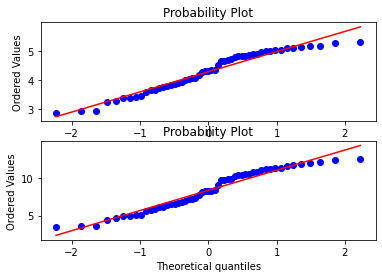

In [20]:
ds = query_by_round_type_tag('QF', 'RC', 2)['score_logit'].values.flatten()

qqplotOriginalVSBoxCox(ds)

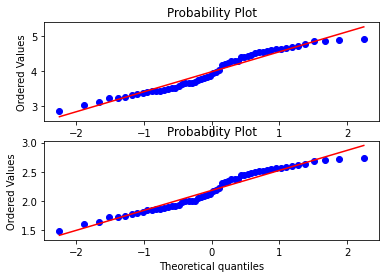

In [21]:
ds = query_by_round_type_tag('QF', 'RC', 5)['score_logit'].values.flatten()

qqplotOriginalVSBoxCox(ds)

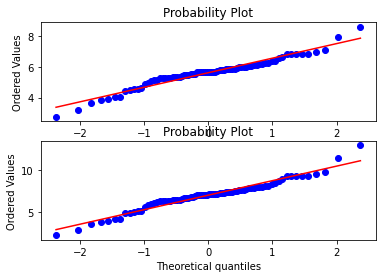

In [22]:
ds = query_by_round_type_tag('RO32', 'RC', 3)['score_logit'].values.flatten()

qqplotOriginalVSBoxCox(ds)

---